In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
from scipy.io import loadmat
from scipy import stats, signal

import matplotlib.pyplot as plt

from pathlib import Path
import os
import sys

from sklearn.decomposition import PCA

import torch
from torch import nn
from torch import functional as F

project_path = Path("C:/Users/aleks/git/frankenstein")
utils_path = project_path / "utils"

sys.path.append(str(utils_path))

from data_utils import process_file, process_all_files, process_string

data_path = Path("D:\data_brain_to_text\competitionData")
train_path = data_path / "train"
test_path  = data_path / "test"
holdout_path = data_path / "competitionHoldOut"

fnames_train = os.listdir(train_path)
fnames_test = os.listdir(test_path)
fnames_holdout = os.listdir(holdout_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First let's align input data

We need to pad it to 3000 samples and reduce to 80 components

## Load train and test data

In [2]:
%%time
data_res_train = process_all_files(train_path)
data_res_test = process_all_files(test_path)

data_res_train.keys()

CPU times: total: 8.02 s
Wall time: 27 s


dict_keys(['brain_list', 'sentence_list', 'date_list'])

## Process BRAIN DATA

**Which inputs the model expects?**

- 30 seconds of 16 kHz audio
- it gets preprocessed by WhisperFeatureExtractor to a spectrogram of size 80 x 3000
- so 30 sec of 100 Hz sampling rate)

### Train PCA

We want to compress the data to 80 components

In [3]:
%%time

brain_list = data_res_train['brain_list']
X = np.concatenate(brain_list, axis=0)[:, :256] # take only voltages
print(X.shape)

pca = PCA().fit(X)

(2768768, 256)
CPU times: total: 46.8 s
Wall time: 22.3 s


In [4]:
def prepare_brain_data_for_whisper(brain_list, pca, n_components=80, pad_length=3000):
    
    # initialize output array 
    brain_processed_arr = np.empty((len(brain_list), n_components, pad_length))  # [N x 80 x 3000]
    
    for i, data in enumerate(brain_list):
        data = data[:, :256]
        # reduce to 80 components and transpose to (n_chan, n_times)
        data_transformed = pca.transform(data)[:, :n_components].T # [80 x n]
        n_times = data_transformed.shape[1]
         # resample from 50 Hz to 100 Hz
        data_resampled = signal.resample(data_transformed, n_times * 2, axis=1)
        # pad to 30 sec (3000 samples in 100 Hz sampling rate)
        data_padded = np.pad(data_resampled, [(0, 0), (0, pad_length - n_times * 2)])
        # fill in values
        brain_processed_arr[i] = data_padded
    
    return brain_processed_arr

### Process data

In [5]:
%%time
brain_arr_train = prepare_brain_data_for_whisper(data_res_train['brain_list'], pca)
brain_arr_train.shape

CPU times: total: 3.7 s
Wall time: 35.1 s


(8800, 80, 3000)

In [9]:
%%time
brain_arr_test = prepare_brain_data_for_whisper(data_res_test['brain_list'], pca)
brain_arr_test.shape

CPU times: total: 203 ms
Wall time: 2.31 s


(880, 80, 3000)

For me it has more of both elements than the majority of its competitors.


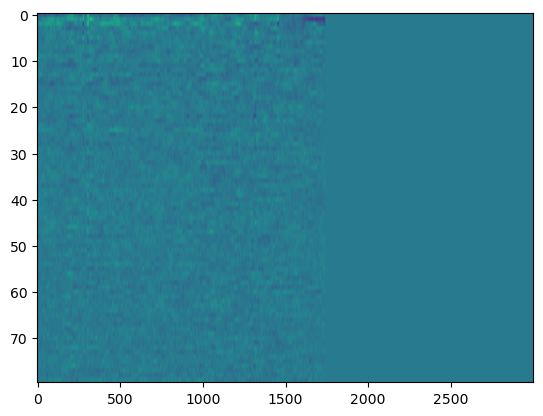

In [36]:
plt.imshow(brain_arr_train[100], aspect='auto')
print(data_res_train['sentence_list'][100])

### Save resulting files

In [7]:
np.save(data_path / "whisper_brain_arr_train.npy", brain_arr_train)
np.save(data_path / "whisper_brain_arr_test.npy", brain_arr_test)

In [ ]:
features_train = np.load(data_path / "whisper_brain_arr_train.npy")
features_test = np.load(data_path / "whisper_brain_arr_test.npy")

## Process SENTENCES

In [48]:
from transformers import WhisperTokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", task="transcribe")

In [85]:
sentences_train = data_res_train['sentence_list']
sentences_test  = data_res_test['sentence_list']

### Test how casing affects tokenization

In [44]:
i = 0
s1 = sentences_test[i]
s2 = process_string(sentences_test[i])

d1 = tokenizer(s1).input_ids
d2 = tokenizer(s2).input_ids

s1_pred = tokenizer.decode(d1)
s2_pred = tokenizer.decode(d2)

print(s1)
print(d1)
print(s1_pred)

print(s2)
print(d2)
print(s2_pred)

Theocracy reconsidered.
[50257, 50358, 50362, 464, 17818, 23898, 3089, 13, 50256]
<|startoftranscript|><|transcribe|><|notimestamps|>Theocracy reconsidered.<|endoftext|>
theocracy reconsidered
[50257, 50358, 50362, 1169, 17818, 23898, 3089, 50256]
<|startoftranscript|><|transcribe|><|notimestamps|>theocracy reconsidered<|endoftext|>


### Process all strings and save to a text file

In [92]:
import string

# version with lowering the case - AFFECTS tokenization!
def process_string(text):
    text = text.lower()
    punctuation = string.punctuation.replace("'", "")
    text = ''.join(char for char in text if char not in punctuation)
    return text

# also affects tokenization but we don't care about punctuation!
def remove_punctuation(text):
    punctuation = string.punctuation.replace("'", "")
    text = ''.join(char for char in text if char not in punctuation)
    return text


def save_sentences_to_txt(fpath, sentences, string_processing_fn):
    with open(fpath, 'w', encoding="utf-8") as file:
        for sentence in sentences:
            file.write(string_processing_fn(sentence) + "\n")
            
            
def load_sentences_from_txt(fpath):
    with open(fpath, 'r', encoding="utf-8") as f:
        sentences = [line.strip() for line in f.readlines()]
    return sentences

In [98]:
string_processing_fn = process_string

fname_train = "whisper_sentences_train.txt"
save_sentences_to_txt(data_path / fname_train, data_res_train['sentence_list'], string_processing_fn)

fname_test = "whisper_sentences_test.txt"
save_sentences_to_txt(data_path / fname_test, data_res_test['sentence_list'], string_processing_fn)

In [100]:
sentences_test = load_sentences_from_txt(data_path / "whisper_sentences_test.txt")
sentences_train = load_sentences_from_txt(data_path / "whisper_sentences_train.txt")

sentences_train[0]

'nuclear rockets can destroy airfields with ease'

## Prepare Whisper dataset

### Sentence tokenizer

In [28]:
from transformers import WhisperFeatureExtractor
from transformers import WhisperTokenizer
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny.en")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", task="transcribe")

### Prepare dataset

In [81]:
class BrainDataset(Dataset):
    def __init__(self, brain_features, sentences, tokenizer):
        self.brain_features = brain_features
        self.sentences = sentences
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.brain_features)

    def __getitem__(self, idx):
        input_features = self.brain_features[idx]
        sentence = self.sentences[idx]

        # Tokenize the sentence
        labels = self.tokenizer(sentence, return_tensors="pt").input_ids.squeeze()

        return {
            "input_features": torch.tensor(input_features),
            "labels": labels,
        }

# Create training and evaluation datasets
train_dataset = BrainDataset(brain_arr_train, sentences_train, tokenizer)
eval_dataset = BrainDataset(brain_arr_test, sentences_test, tokenizer)

In [82]:
train_dataset[0]

{'input_features': tensor([[ 5.3771,  6.0706,  5.4985,  ...,  0.0000,  0.0000,  0.0000],
         [-0.4956,  0.0681, -0.3296,  ...,  0.0000,  0.0000,  0.0000],
         [-1.2867, -1.2222, -1.1686,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.4317,  0.4389,  0.6194,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1586,  0.0664, -0.1886,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.4949,  0.3686,  0.1017,  ...,  0.0000,  0.0000,  0.0000]],
        dtype=torch.float64),
 'labels': tensor([50257, 50358, 50362,    45,  4016, 20293,   460,  4117,  1633, 25747,
           351, 10152,    13, 50256])}

In [86]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    
    feature_extractor: Any
    tokenizer: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # first treat the BRAIN INPUTS (already preprocessed)
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [89]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

NameError: name 'model' is not defined

In [2]:
""" LOAD PRETRAINED MODEL COMPONENTS """

import torch
from torch import nn
from torch import functional as F

WHISPER_MODEL_NAME = "openai/whisper-tiny.en"

from transformers import WhisperTokenizer, WhisperFeatureExtractor
from transformers import GenerationConfig
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# load feature/label processing engines
feature_extractor = WhisperFeatureExtractor.from_pretrained(WHISPER_MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(WHISPER_MODEL_NAME, task="transcribe")
# load model
model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME)
#model.generation_config.language = "english"
#model.generation_config.task = "transcribe"
#model.generation_config.forced_decoder_ids = None

from dataclasses import dataclass
from typing import Any, Dict, List, Union

import evaluate
metric = evaluate.load("wer")

from torchsummary import summary
summary(model);

Layer (type:depth-idx)                             Param #
├─WhisperModel: 1-1                                --
|    └─WhisperEncoder: 2-1                         --
|    |    └─Conv1d: 3-1                            92,544
|    |    └─Conv1d: 3-2                            442,752
|    |    └─Embedding: 3-3                         (576,000)
|    |    └─ModuleList: 3-4                        7,096,320
|    |    └─LayerNorm: 3-5                         768
|    └─WhisperDecoder: 2-2                         --
|    |    └─Embedding: 3-6                         19,915,776
|    |    └─WhisperPositionalEmbedding: 3-7        172,032
|    |    └─ModuleList: 3-8                        9,463,296
|    |    └─LayerNorm: 3-9                         768
├─Linear: 1-2                                      19,915,776
Total params: 57,676,032
Trainable params: 57,100,032
Non-trainable params: 576,000


In [3]:
model.get_decoder()

WhisperDecoder(
  (embed_tokens): Embedding(51864, 384, padding_idx=50256)
  (embed_positions): WhisperPositionalEmbedding(448, 384)
  (layers): ModuleList(
    (0-3): 4 x WhisperDecoderLayer(
      (self_attn): WhisperSdpaAttention(
        (k_proj): Linear(in_features=384, out_features=384, bias=False)
        (v_proj): Linear(in_features=384, out_features=384, bias=True)
        (q_proj): Linear(in_features=384, out_features=384, bias=True)
        (out_proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (activation_fn): GELUActivation()
      (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (encoder_attn): WhisperSdpaAttention(
        (k_proj): Linear(in_features=384, out_features=384, bias=False)
        (v_proj): Linear(in_features=384, out_features=384, bias=True)
        (q_proj): Linear(in_features=384, out_features=384, bias=True)
        (out_proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (e

In [7]:
model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 384)
      (layers): ModuleList(
        (0-3): 4 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=True)
            (q_proj): Linear(in_features=384, out_features=384, bias=True)
            (out_proj): Linear(in_features=384, out_features=384, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          

In [14]:
for param in model.get_decoder().parameters():
    param.requires_grad = True
    
summary(model);

Layer (type:depth-idx)                             Param #
├─WhisperModel: 1-1                                --
|    └─WhisperEncoder: 2-1                         --
|    |    └─Conv1d: 3-1                            92,544
|    |    └─Conv1d: 3-2                            442,752
|    |    └─Embedding: 3-3                         (576,000)
|    |    └─ModuleList: 3-4                        7,096,320
|    |    └─LayerNorm: 3-5                         768
|    └─WhisperDecoder: 2-2                         --
|    |    └─Embedding: 3-6                         19,915,776
|    |    └─WhisperPositionalEmbedding: 3-7        172,032
|    |    └─ModuleList: 3-8                        9,463,296
|    |    └─LayerNorm: 3-9                         768
├─Linear: 1-2                                      19,915,776
Total params: 57,676,032
Trainable params: 57,100,032
Non-trainable params: 576,000
